# 09. Milestone Project 2: SkimLit 📄🔥

In the previous notebook ([NLP fundamentals in TensorFlow](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb)), we went through some fundamental natural lanuage processing concepts. The main ones being **tokenzation** (turning words into numbers) and **creating embeddings** (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.



### Model output

And returns the following output:

```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
 ```

### Problem in a sentence

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

### Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

## What we're going to cover

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-02-07 01:25:47.856682


## Confirm access to a GPU


In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-797802ed-7a7a-42a8-a60a-c280bc169a99)


## Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

We can copy them to our local directory using `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`.

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 31.05 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the [README file](https://github.com/Franck-Dernoncourt/pubmed-rct) from the GitHub page, we get the following information:
* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with `@` but we didn't.


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


Beautiful, looks like we've got three separate text files:
* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [5]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

> Visualize, visualize, visualize!

To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath to read.

  Returns:
    A list of strings with one string per line from the target filename.
    For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()


Alright, we've got a little function, `get_lines()` which takes the filepath of a text file, opens it, reads each of the lines and returns them.

Let's try it out on the training data (`train.txt`).

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # The whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:  
  * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 437 ms, sys: 98.4 ms, total: 536 ms
Wall time: 536 ms


(180040, 30212, 30135)

How do our training samples look?

In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Fantastic! Looks like our `preprocess_text_with_line_numbers()` function worked great.

How about we turn our list of dictionaries into pandas DataFrame's so we visualize them better?

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Looks like sentences with the `OBJECTIVE` label are the least common.

How about we check the distribution of our abstract lengths?

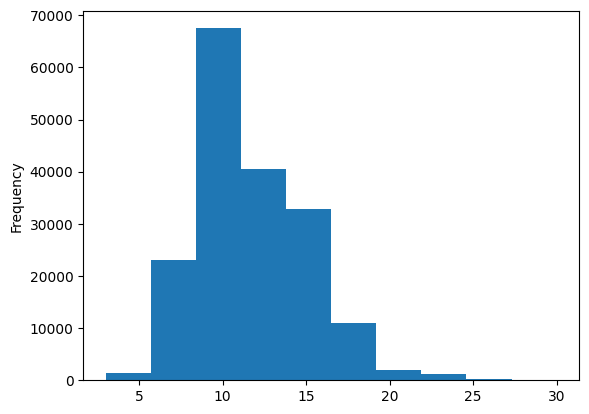

In [14]:
train_df.total_lines.plot.hist();

### Get lists of sentences


In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)


In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

Now we've trained an instance of `LabelEncoder`, we can get the class names and number of classes using the `classes_` attribute.

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [21]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the `calculate_results()` function we created in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb) and added it to our [`helper_functions.py` script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) to compare them to the ground truth labels.

More specificially the `calculate_results()` function will help us obtain the following:
* Accuracy
* Precision
* Recall
* F1-score

### Download helper functions script

Let's get our `helper_functions.py` script we've been using to store helper functions we've created in previous notebooks.

In [23]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-07 01:26:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-07 01:26:13 (71.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Now we've got the helper functions script we can import the `caculate_results()` function and see how our baseline model went.

In [24]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

How about the distribution of sentence lengths?

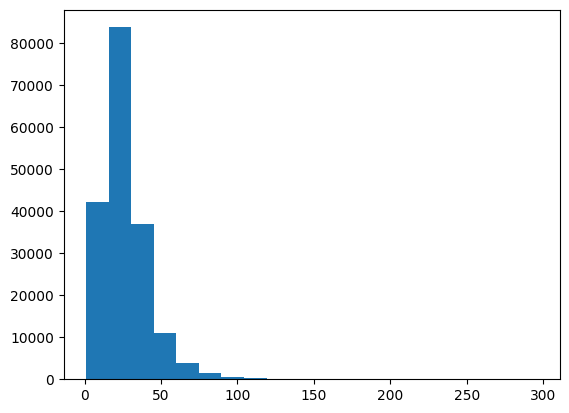

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [29]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### Create text vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

In [30]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our `output_sequence_length` parameter.

In [31]:
# Create text vectorizer

# After TensorFlow 2.6
from tensorflow.keras.layers import TextVectorization

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

Our `text_vectorizer` is ready, now we need to adapt it to the training data (let it read the training data and figure out what number should represent what word) and then test it out.

In [32]:
# Adapt  text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the mothers will receive regular , personalised , home-based counselling by trained community health workers on miycn .

Length of text: 18

Vectorized text:
[[    2  1143    95   175  1004 10221  2427  2540    22  1344   613    97
   1693    18 30059     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) method of our `text_vectorizer` we can find out a few different tidbits about our text.

In [34]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


And if we wanted to figure out the configuration of our `text_vectorizer` we can use the `get_config()` method.

In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the mothers will receive regular , personalised , home-based counselling by trained community health workers on miycn .

Sentence after vectorization (before embedding):
[[    2  1143    95   175  1004 10221  2427  2540    22  1344   613    97
   1693    18 30059     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.01446218 -0.00274464  0.03345505 ... -0.00744199 -0.01244963
    0.03709504]
  [-0.02144946 -0.01768786  0.01590342 ... -0.02990508  0.03418566
    0.00287471]
  [ 0.04825721  0.03079912 -0.02766013 ... -0.0010832  -0.03889245
   -0.0018819 ]
  ...
  [-0.03470006  0.01688666 -0.01591723 ...  0.00667393  0.0306181
    0.00555557]
  [-0.03470006  0.01688666 -0.01591723 ...  0.00667393  0.0306181
    0.00555557]
  [-0.03470

## Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data` API provides methods which enable faster data loading.



In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the `Layers` component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)


In [39]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [41]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 21s 33ms/step - loss: 0.9115 - accuracy: 0.6428 - val_loss: 0.6770 - val_accuracy: 0.7424
Epoch 2/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6499 - accuracy: 0.7607 - val_loss: 0.6247 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6121 - accuracy: 0.7761 - val_loss: 0.5948 - val_accuracy: 0.7832


In [100]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)


945/945 [==============================] - 6s 6ms/step - loss: 0.5946 - accuracy: 0.7883


[0.5946212410926819, 0.7882629632949829]

In [101]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.7164991e-01, 1.4249231e-01, 4.6480067e-02, 3.0638775e-01,
        3.2989960e-02],
       [4.2519110e-01, 3.2874593e-01, 1.5419695e-02, 2.1826519e-01,
        1.2378080e-02],
       [1.9401030e-01, 5.8973962e-03, 3.0297700e-03, 7.9700625e-01,
        5.6212230e-05],
       ...,
       [8.2781971e-06, 6.1772432e-04, 6.5513607e-04, 3.7337318e-06,
        9.9871516e-01],
       [4.7490064e-02, 5.2965492e-01, 7.4852370e-02, 4.8400819e-02,
        2.9960185e-01],
       [1.4545061e-01, 7.0805532e-01, 5.4136287e-02, 5.0633591e-02,
        4.1724220e-02]], dtype=float32)

In [104]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [105]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.82629418773998,
 'precision': 0.7850073496802443,
 'recall': 0.7882629418773998,
 'f1': 0.7858037189136808}


The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.


In [42]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, # Using only as a feature extractor, (we are not fine-tuning it)
                                        name="universal_sentence_encoder")

In [43]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
moreover , public health authorities identified the need for information to develop locally appropriate h. pylori control strategies .

Sentence after embedding:
[ 0.02835407  0.08059116  0.00820854 -0.03084673  0.00929564  0.05664794
  0.07314057  0.04470077  0.03852578 -0.04293091  0.08529339  0.01966062
  0.00347493 -0.00516819 -0.02269319  0.0799646  -0.08996379 -0.00716032
 -0.05602553  0.00703459 -0.03682021 -0.07745316 -0.03558185  0.0105198
  0.04243462 -0.00105246  0.01922304  0.02177162  0.02516539 -0.05596464] (truncated output)...

Length of sentence embedding:
512


Nice! As we mentioned before the pretrained USE module from TensorFlow Hub takes care of tokenizing our text for us and outputs a 512 dimensional embedding vector.

Let's put together and compile a model using our `tf_hub_embedding_layer`.

### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [44]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Checking the summary of our model we can see there's a large number of total parameters, however, the majority of these are non-trainable. This is because we set `training=False` when we instatiated our USE feature extractor layer.

So when we train our model, only the top two output layers will be trained.

In [46]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [47]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9134 - accuracy: 0.6512 - val_loss: 0.7966 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7700 - accuracy: 0.7008 - val_loss: 0.7557 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7551 - accuracy: 0.7105 - val_loss: 0.7421 - val_accuracy: 0.7124


In [48]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7442 - accuracy: 0.7118


[0.7442012429237366, 0.7117701768875122]

Since we aren't training our own custom embedding layer, training is much quicker.

Let's make some predictions and evaluate our feature extraction model.

In [49]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[4.4241390e-01, 3.4006837e-01, 2.3934452e-03, 2.0694166e-01,
        8.1827259e-03],
       [3.6956835e-01, 4.8122934e-01, 3.8521811e-03, 1.4125997e-01,
        4.0901038e-03],
       [2.2791722e-01, 1.3124645e-01, 1.5570627e-02, 5.9097213e-01,
        3.4293558e-02],
       ...,
       [1.7297302e-03, 5.9597655e-03, 5.6951385e-02, 7.6489482e-04,
        9.3459427e-01],
       [4.0436438e-03, 4.2463288e-02, 1.7900133e-01, 1.3549168e-03,
        7.7313685e-01],
       [1.7734940e-01, 2.4137664e-01, 5.1667964e-01, 8.8406438e-03,
        5.5753656e-02]], dtype=float32)

In [50]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [51]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.17701575532901,
 'precision': 0.7121174138766334,
 'recall': 0.7117701575532901,
 'f1': 0.708798815897024}

## Model 3: Conv1D with character embeddings


### Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

![example of difference between token level and character level embeddings](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)
*Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.*

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [52]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'm o r e o v e r   ,   p u b l i c   h e a l t h   a u t h o r i t i e s   i d e n t i f i e d   t h e   n e e d   f o r   i n f o r m a t i o n   t o   d e v e l o p   l o c a l l y   a p p r o p r i a t e   h .   p y l o r i   c o n t r o l   s t r a t e g i e s   .'

In [53]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [54]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

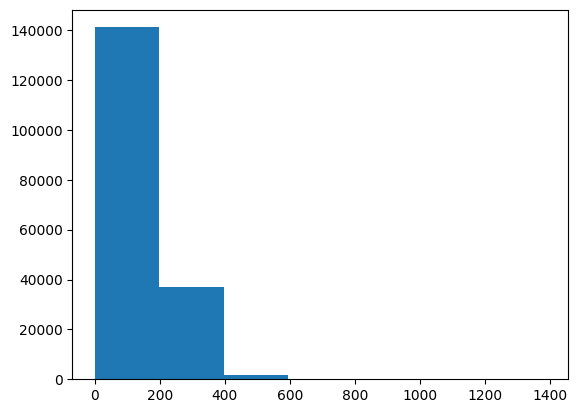

In [55]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [56]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Wonderful, now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

> 🔑 **Note:** You can experiment here to figure out what the optimal `output_sequence_length` should be, perhaps using the mean results in as good results as using the 95% percentile.

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [57]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [58]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Nice! Now we've adapted our `char_vectorizer` to our character-level sequences, let's check out some characteristics about it using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization#get_vocabulary) method.

In [59]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


We can also test it on random sequences of characters to make sure it's working.

In [60]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   @   %   c i   o f   t h e   r a t i o s   o f   t h e   l o g - t r a n s f o r m e d   v a l u e s   o f   a u c l a s t   a n d   a u c   w a s   @ - @   @   .

Length of chars: 67

Vectorized chars:
[[ 3 13  2 11  4  7 17  3 13  2  8  5  3  4  7  9  7 17  3 13  2 12  7 18
   3  8  5  6  9 17  7  8 15  2 10 21  5 12 16  2  9  7 17  5 16 11 12  5
   9  3  5  6 10  5 16 11 20  5  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0

You'll notice sequences with a length shorter than 290 (`output_seq_char_length`) get padded with zeros on the end, this ensures all sequences passed to our model are the same length.

Also, due to the `standardize` parameter of `TextVectorization` being `"lower_and_strip_punctuation"` and the `split` parameter being `"whitespace"` by default, symbols (such as `@`) and spaces are removed.

> 🔑 **Note:** If you didn't want punctuation to be removed (keep the `@`, `%` etc), you can create a custom standardization callable and pass it as the `standardize` parameter. See the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer documentation for more.


### Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.

Our character-level embedding layer requires an input dimension and output dimension.

The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [61]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   @   %   c i   o f   t h e   r a t i o s   o f   t h e   l o g - t r a n s f o r m e d   v a l u e s   o f   a u c l a s t   a n d   a u c   w a s   @ - @   @   .

Embedded chars (after vectorization and embedding):
[[[ 0.02171699  0.02542115 -0.03310569 ...  0.02026543 -0.02315723
    0.02054942]
  [-0.00943182 -0.01413405 -0.02395637 ...  0.03879041  0.00140513
   -0.00756767]
  [ 0.01591947  0.02447028 -0.01819469 ...  0.00229293 -0.04514661
   -0.03533686]
  ...
  [ 0.03939964  0.02027878 -0.01692446 ... -0.01873189  0.00955073
    0.04537654]
  [ 0.03939964  0.02027878 -0.01692446 ... -0.01873189  0.00955073
    0.04537654]
  [ 0.03939964  0.02027878 -0.01692446 ... -0.01873189  0.00955073
    0.04537654]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`) except it'll take character-level sequences as input instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)
```


In [62]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`'s.

In [64]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [65]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2592 - accuracy: 0.4929 - val_loss: 1.0435 - val_accuracy: 0.5928
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0050 - accuracy: 0.6015 - val_loss: 0.9405 - val_accuracy: 0.6316
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9306 - accuracy: 0.6365 - val_loss: 0.8794 - val_accuracy: 0.6609


In [66]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.8900 - accuracy: 0.6542


[0.8900324702262878, 0.6542433500289917]

**Nice**! Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [67]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.2162035 , 0.44064856, 0.0706706 , 0.20976156, 0.06271576],
       [0.25386846, 0.5785895 , 0.0127408 , 0.12172117, 0.03308013],
       [0.10084447, 0.21226752, 0.39496544, 0.19688459, 0.09503797],
       ...,
       [0.00892623, 0.02299443, 0.09569664, 0.01305231, 0.8593304 ],
       [0.02940509, 0.04980855, 0.41224504, 0.02102933, 0.487512  ],
       [0.42603043, 0.31004137, 0.17884691, 0.0632569 , 0.02182439]],
      dtype=float32)

In [68]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [69]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.42433470144313,
 'precision': 0.6441590726184483,
 'recall': 0.6542433470144313,
 'f1': 0.6411155634645542}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Alright, now things are going to get spicy.

In moving closer to build a model similar to the one in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:
1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

4.2 Training


The model is trained using stochastic gradient descent, updating all parameters, i.e., token embeddings, character embeddings, parameters of bidirectional LSTMs, and transition probabilities, at
each gradient step. For regularization, dropout
with a rate of 0.5 is applied to the characterenhanced token embeddings and before the label
prediction layer.


In [70]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybid")([token_model.output, char_model.output])


# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [71]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

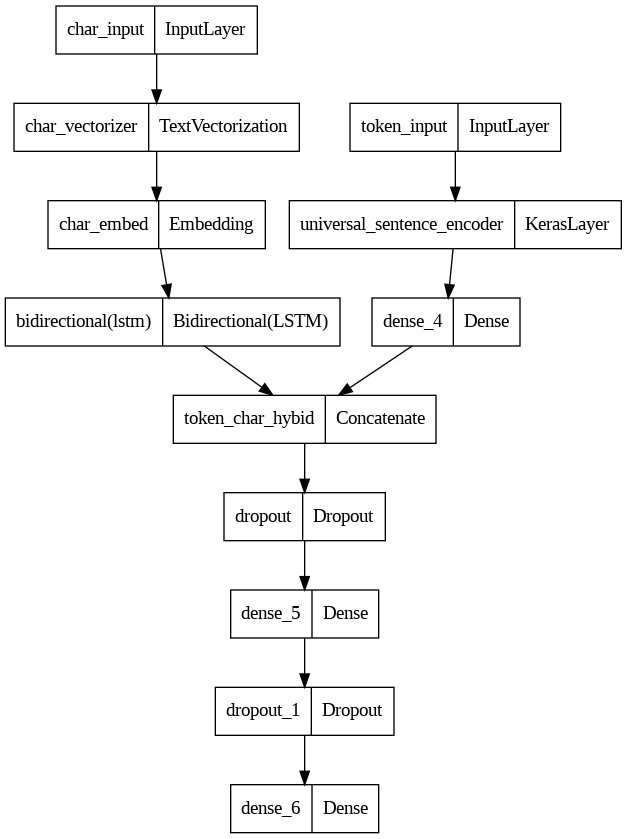

In [72]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

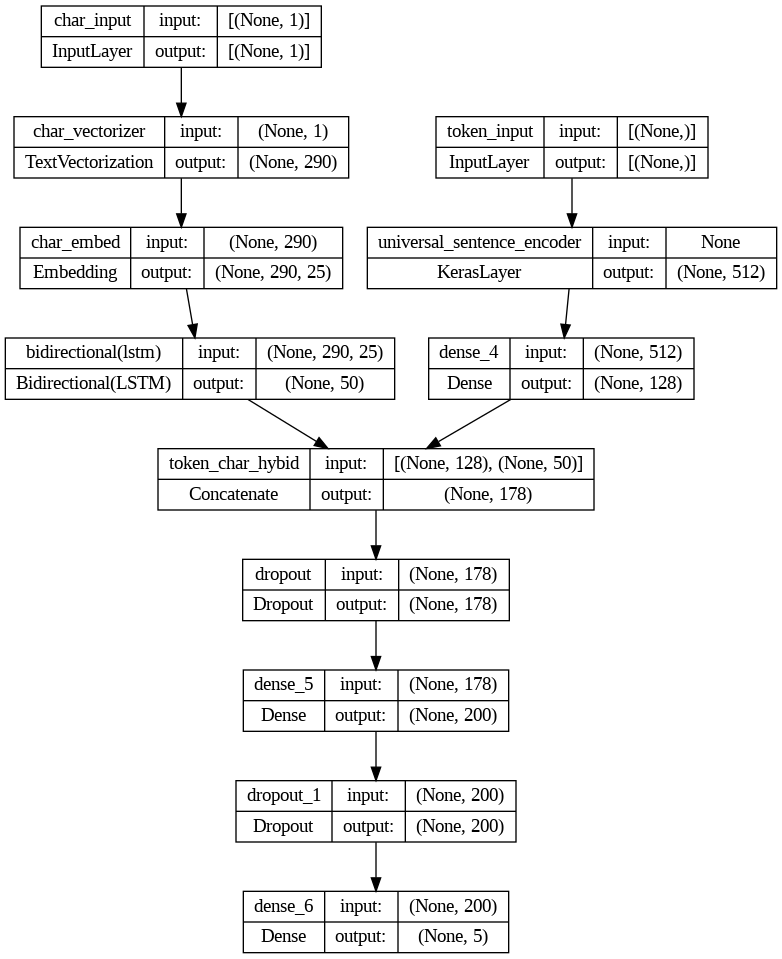

In [73]:
plot_model(model_4, show_shapes=True)

In [74]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

In [75]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [76]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [77]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 30s 41ms/step - loss: 0.9668 - accuracy: 0.6117 - val_loss: 0.7819 - val_accuracy: 0.7008
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 0.7966 - accuracy: 0.6935 - val_loss: 0.7163 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7699 - accuracy: 0.7004 - val_loss: 0.6880 - val_accuracy: 0.7367


In [78]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6939 - accuracy: 0.7321


[0.6938561797142029, 0.7321262955665588]

In [79]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[3.8447201e-01, 3.9435288e-01, 3.7803466e-03, 2.1009827e-01,
        7.2965389e-03],
       [3.0588076e-01, 5.0771481e-01, 3.2166860e-03, 1.8063547e-01,
        2.5522953e-03],
       [3.3855543e-01, 1.3713664e-01, 7.2990112e-02, 4.1756001e-01,
        3.3757750e-02],
       ...,
       [7.3658524e-04, 1.0598198e-02, 5.4291092e-02, 3.1392390e-04,
        9.3406022e-01],
       [4.7910684e-03, 8.5016929e-02, 1.7584009e-01, 2.0824547e-03,
        7.3226947e-01],
       [2.3350260e-01, 4.3149585e-01, 2.3395035e-01, 3.3647679e-02,
        6.7403555e-02]], dtype=float32)

In [80]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [81]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.21263074275123,
 'precision': 0.7329268125657642,
 'recall': 0.7321263074275123,
 'f1': 0.7280635371259977}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [82]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


If we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

### Create positional embeddings


In [83]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

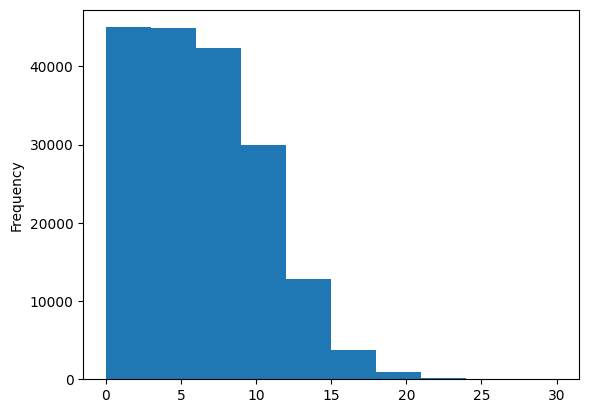

In [84]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [85]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [86]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [87]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [88]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "totla_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [89]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

Visualize the summary

In [90]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

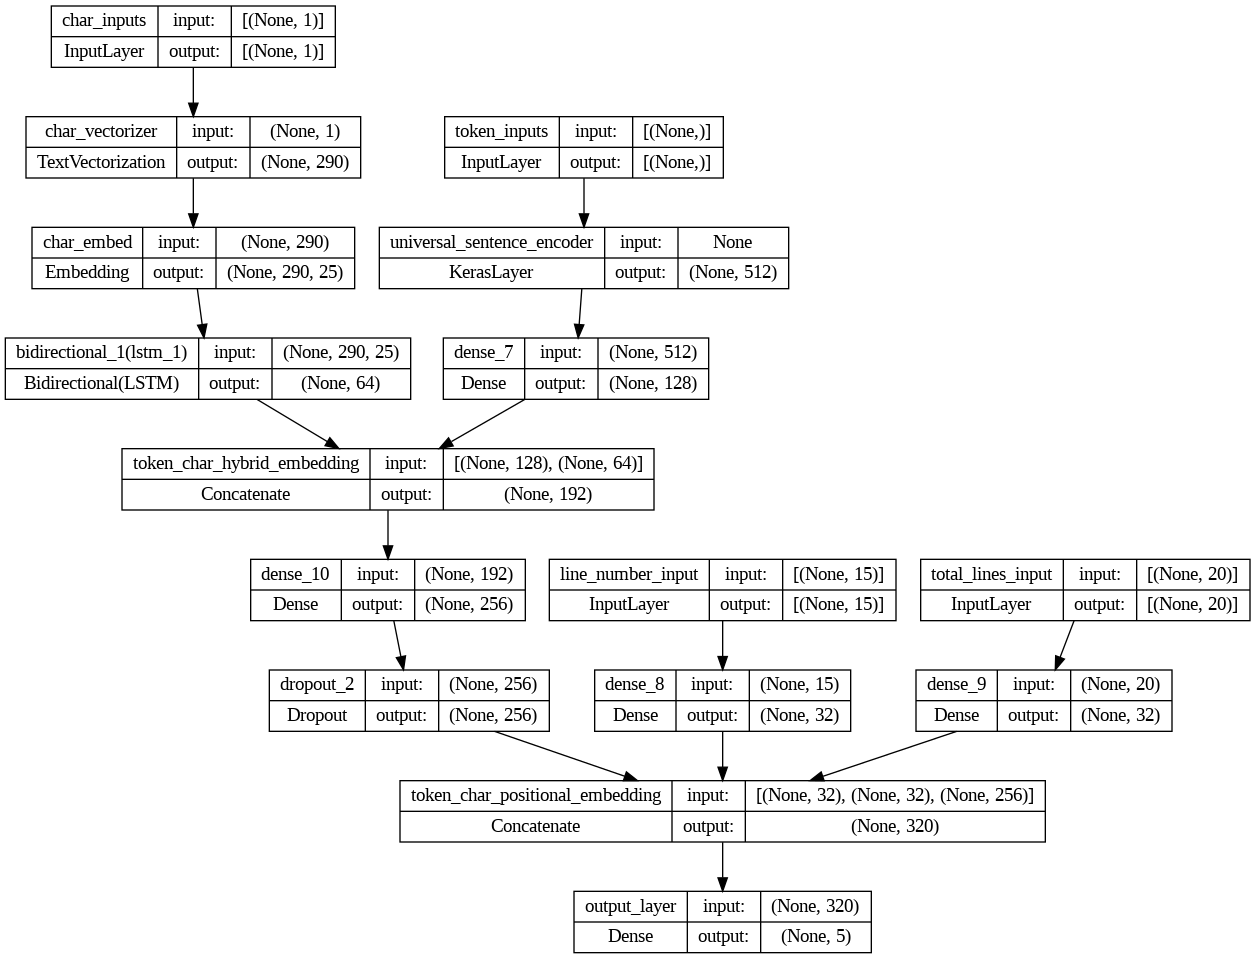

In [91]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [92]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b68edfe1900> True
<keras.src.engine.input_layer.InputLayer object at 0x7b68edfe1120> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7b6851325c60> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7b696e217340> False
<keras.src.layers.core.embedding.Embedding object at 0x7b6851351690> True
<keras.src.layers.core.dense.Dense object at 0x7b68edfe3a00> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7b68ede27cd0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7b68ede79600> True
<keras.src.engine.input_layer.InputLayer object at 0x7b696f733f10> True
<keras.src.engine.input_layer.InputLayer object at 0x7b68ede27190> True
<keras.src.layers.core.dense.Dense object at 0x7b68edd27970> True
<keras.src.layers.core.dense.Dense object at 0x7b69c1b40f40> True
<keras.src.layers.core.dense.Dense object at 0x7b6960283970> True
<keras.src.layers.regularization.dropout.

In [93]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing to help prevent overfitting (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What is label smoothing?

For example, if our model gets too confident on a single class (e.g., its prediction probability is really high), it may get stuck on that class and not consider other classes...


For example, instead of having an output prediction of:
* `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:
* `[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.


### Create tribrid embedding datasets and fit tribrid model

Model compiled!

Again, to keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [94]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [95]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 42ms/step - loss: 1.0936 - accuracy: 0.7259 - val_loss: 0.9840 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9676 - accuracy: 0.8142 - val_loss: 0.9528 - val_accuracy: 0.8245
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9511 - accuracy: 0.8241 - val_loss: 0.9386 - val_accuracy: 0.8308


In [96]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 27s 27ms/step


array([[0.5070381 , 0.11235657, 0.01114063, 0.35407823, 0.0153865 ],
       [0.540025  , 0.09465325, 0.04361893, 0.30995813, 0.01174468],
       [0.3022752 , 0.10812712, 0.13577184, 0.39139962, 0.06242624],
       ...,
       [0.03532137, 0.08858805, 0.03096125, 0.03057031, 0.814559  ],
       [0.02717615, 0.29452458, 0.07841235, 0.02798045, 0.5719065 ],
       [0.242738  , 0.5578425 , 0.0958969 , 0.04817804, 0.05534459]],
      dtype=float32)

In [97]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [98]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.27154772937905,
 'precision': 0.8318633366554724,
 'recall': 0.8327154772937906,
 'f1': 0.8316979044364734}

## Compare model results

Far out, we've come a long way. From a baseline model to training a model containing three different kinds of embeddings.

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [106]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.826294,0.785007,0.788263,0.785804
pretrained_token_embed,71.177016,0.712117,0.711770,0.708799
custom_char_embed_conv1d,65.424335,0.644159,0.654243,0.641116
hybrid_char_token_embed,73.212631,0.732927,0.732126,0.728064
tribrid_pos_char_token_embed,83.271548,0.831863,0.832715,0.831698


In [107]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

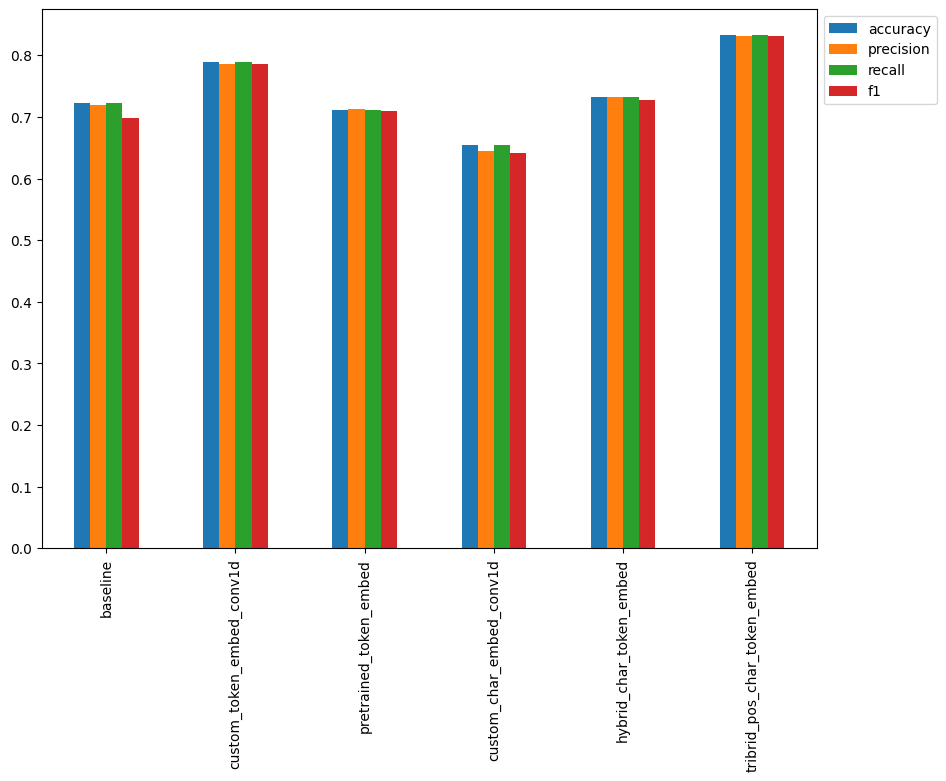

In [108]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

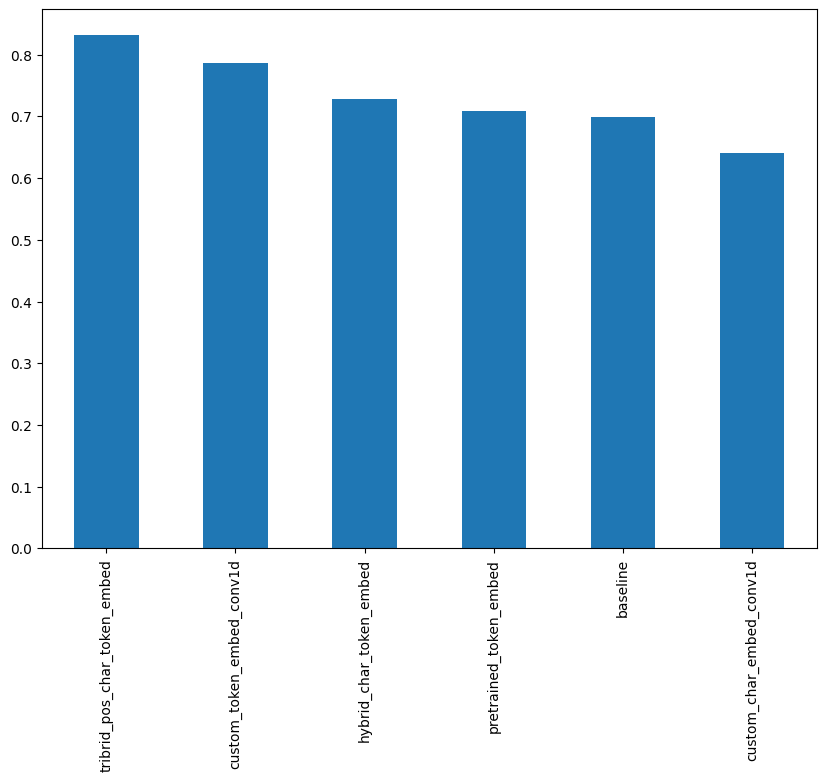

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

Based on F1-scores, it looks like our tribrid embedding model performs the best by a fair margin.


## Save and load best performing model

We can save our best performing model by calling the [`save()`](https://www.tensorflow.org/guide/keras/save_and_serialize#the_short_answer_to_saving_loading) method on it.

In [110]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string

In [111]:
# Example of copying saved model from Google Colab to Drive (requires Google Drive to be mounted)
# !cp skimlit_best_model -r /content/drive/MyDrive/tensorflow_course/skim_lit

In [114]:
# Download pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2024-02-07 01:43:02--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf, 2607:f8b0:4023:c03::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  63.3MB/s    in 12s     

2024-02-07 01:43:14 (78.2 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs

In [115]:
# Import TensorFlow model dependencies (if needed) - https://github.com/tensorflow/tensorflow/issues/38250
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_gs_model/skimlit_tribrid_model/"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)#,
                                          # Note: with TensorFlow 2.5+ if your SavedModel has a keras_metadata.pb file
                                          # (created when using model.save()), you shouldn't need the custom_objects
                                          # parameter. I'm leaving the code below here in case you do.
                                          # custom_objects={"TextVectorization": TextVectorization, # required for char vectorization
                                          #                 "KerasLayer": hub.KerasLayer}) # required for token embedding

### Make predictions and evalaute them against the truth labels


In [116]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 26s 25ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [117]:
# Evaluate loaded model's predictions
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.03323182841254,
 'precision': 0.8290556618130785,
 'recall': 0.8303323182841255,
 'f1': 0.8294263092000485}

In [118]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

In [119]:
# Check loaded model summary (note the number of trainable parameters)
loaded_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  